# Facebook Message Analyzer

<b> Current Features For a Given Chat: </b>
<ul> 
    <li> Number of Messages Sent </li> 
    <li> Messages Sent Over Time </li> 
    <li> Average Word Count </li>
</ul>

In [16]:
# Modified by Ashley Zhuang and Tarun Prasad

import os
import json
import numpy as np
import pylab as pl
import datetime

CURRENT_DIRECTORY = os.getcwd()
NUMBER_TO_ANALYZE = 5000
MESSAGE_THRESHOLD = 10
MESSAGE_BOUND = 1000
# PARTICIPANT_BOUND = 2
RESPONSE_TIME_BOUND = 60 * 3 # set bound for active conversation to 3 hours


In [17]:
def concat_content(content_list):
    output = ''
    
    for message in content_list:
        output += message + '. '
        
    return output

def calc_grade_level(text):
    words = 1
    letters = 0
    sentences = 0
    
    for i in range(len(text)):
        if text[i].isalpha():
            letters += 1
        elif text[i].isspace() and i != 0 and i != len(text) - 1 and not text[i - 1].isspace():
            words += 1
        elif ispunct(text[i]) and i != 0 and not ispunct(text[i - 1]):
            sentences += 1
            
    L = float(letters) / words * 100
    S = float(sentences) / words * 100
    grade = round(0.0588 * L - 0.296 * S - 15.8)
    
    return grade

def ispunct(char):
    if char == '?' or char == '!' or char == '.':
        return True
    return False


In [18]:
def get_json_data(chat):
    try:
        json_location = CURRENT_DIRECTORY + "/messages/inbox/" + chat + "/message_1.json"
        with open(json_location) as json_file:
            json_data = json.load(json_file)
            return json_data
    except IOError:
        pass # some things the directory aren't messages (DS_Store, stickers_used, etc.)

In [19]:
chats = os.listdir(CURRENT_DIRECTORY + "/messages/inbox/")[:NUMBER_TO_ANALYZE]
sorted_chats = []
final_data_messages = {}
final_data_times = {}
final_data_words = {}
final_data_response_times = {}
final_data_reacts = {}
final_data_content = {}
final_data_hours = {}
invalid_message_count = 0

In [20]:
print('Analyzing ' + str(min(NUMBER_TO_ANALYZE, len(chats))) + ' chats...')

for chat in chats:
    url = chat + '/message_1.json'
    json_data = get_json_data(chat)
    print(chat)
    if json_data != None:
        messages = json_data["messages"]
        participants = json_data["participants"]
        if len(messages) >= MESSAGE_THRESHOLD and len(messages) <= MESSAGE_BOUND: #and len(participants) <= PARTICIPANT_BOUND:
            sorted_chats.append((len(messages), chat, messages))

sorted_chats.sort(reverse=True)

print('Finished processing chats...')

Analyzing 227 chats...
stephaniezhang_k33t7fflow
CAPASkit_mxpIICcVUg
PearlLi_KkVsFj1XGg
jennajorgenson_sfesug_f0w
shwenakak_mclvfvdmuq
juliacleric_evf_md26mq
ingridhsu_7zouc3ynvq
thomastran_jqwv5apoyq
AnnaJMount_9KCrhoLuCw
sarahzhang_pxj6kif8iq
brookenoble_etkc3bktcg
raquellindo_mfmdta2ega
jackwilks_ofi8hzc7bq
helenchang_kvqwcwtjjw
marianneroseregiscalub_fh1cvzw9sa
jaredsavas_c5jebu5qta
kimberlywang_ypy3jk2ywa
shinwang_jfhjraz8na
allyssageorge_fkkrx-8mvq
jonathanye_d1b0uo96pw
sydneyleong_xymq-l0h5a
shannadelatorre_5ak8r47tzg
gracechen_la7l_1uizw
sarahdeng_ev8zhkpgsg
brittaneycarter_temnuqs2va
AliceWang_KPgpfwsS2Q
maxandalice_gbsd9yrvca
chrisyu_uzmssalmzw
galaxyexplorers_dovrz634lw
janphilipadlawan_ph92afcigg
elijahmaravilla_rmofi7f_7w
vigneshrao_pae0ttl56g
iankimbell_pnkjel9pug
ashtonlam_apyrdv4etg
ashleywong_2av37vnmwg
emilymontalvo_q9trnwfjaw
KatieDunn_jbnLcDveew
juliarocha_ziadddwszw
andrewboydbechtold_5rdj33p_dg
CPW_vqf56tbAQg
larryzheng_xz_q3_bbfa
angelhoyang_cgn6qkqvmg
samanthali

In [54]:
for i, (messages, chat, messages) in enumerate(sorted_chats):
    number_messages = {}
    person_to_times = {}
    number_words = {}
    response_times = {}
    number_reacts = {}
    person_to_content = {}
    hour_list = []

    print(str(i) + " - " + str(len(messages)) + " messages - " + str(chat))
    
    last_person = ""
    last_time = 0
    first_message = True

    for message in messages:
        try:
            name = message["sender_name"]
            time = message["timestamp_ms"]
            message_content = message["content"]
            
            if name != last_person and not first_message and (last_time - time) / (1000 * 60) <= RESPONSE_TIME_BOUND:
                response_times[last_person] = response_times.get(last_person, [])
                response_times[last_person].append((last_time - time) / (1000 * 60)) # time in minutes
                
            first_message = False
            last_time = time
            last_person = name
            
            if message.get("reactions", False):
                number_reacts[name] = number_reacts.get(name, 0)
                for reaction in message["reactions"]:
                    number_reacts[name] += 1
            
            person_to_content[name] = person_to_content.get(name, [])
            person_to_content[name].append(message_content)
            

            number_messages[name] = number_messages.get(name, 0)
            number_messages[name] += 1

            person_to_times[name] = person_to_times.get(name, [])
            person_to_times[name].append(datetime.datetime.fromtimestamp(time/1000.0))
            
            hour = (datetime.datetime.fromtimestamp(time/1000.0)).hour
            hour_list.append(hour)

            number_words[name] = number_words.get(name, [])
            number_words[name].append(len(message_content.split()))
        except KeyError:
            # happens for special cases like users who deactivated, unfriended, blocked
            invalid_message_count += 1
    
    for person in person_to_content:
        person_to_content[person] = calc_grade_level(concat_content(person_to_content[person]))
    
    final_data_messages[i] = number_messages
    final_data_times[i] = person_to_times
    final_data_words[i] = number_words
    final_data_response_times[i] = response_times
    final_data_reacts[i] = number_reacts
    final_data_hours[i] = hour_list
    final_data_content[i] = person_to_content
    
    
    
#print(final_data_content)

print('Found ' + str(invalid_message_count) + ' invalid messages...')
print('Found ' + str(len(sorted_chats)) + ' chats with ' + str(MESSAGE_THRESHOLD) + ' messages or more')

0 - 821 messages - HowieGuo_LuHYfG58AQ
1 - 500 messages - WilmerLin_Tk6V3ViqpA
2 - 500 messages - RamonaPark_gTfcvNFuYw
3 - 450 messages - PearlLi_KkVsFj1XGg
4 - 437 messages - HartfordCT_X6FTkA-nQg
5 - 419 messages - MaggieZhang_QibxStDT9Q
6 - 401 messages - eddiesong_yo6v-gimxa
7 - 268 messages - CAPASkit_mxpIICcVUg
8 - 226 messages - TriValleyMIT2023_4z119WZvag
9 - 222 messages - JamesWang_ahPzq2MNqw
10 - 190 messages - jessicasun_not8otqana
11 - 178 messages - MauveseandYubin_XhTQM0Q0Kg
12 - 142 messages - EmilyFang_l6lp_v85MA
13 - 101 messages - mirandaxie_brls1i0tmq
14 - 97 messages - PearlMaggieandMilena_AM9j1LUDtQ
15 - 84 messages - ashersfriends_Sv286qBJsA
16 - 77 messages - jonathanye_d1b0uo96pw
17 - 74 messages - larryzheng_xz_q3_bbfa
18 - 69 messages - jessicafeng_nhuw1hqp_q
19 - 68 messages - PearlKatieandMauvese_z_QI4XrebA
20 - 68 messages - CPW_vqf56tbAQg
21 - 67 messages - milenamathew_elmh-slw7a
22 - 67 messages - PearlAmyEmilyand2others_-kI886xqXg
23 - 63 messages - B

In [55]:
def plot_num_messages(chat_number):
    plotted_data = final_data_messages[chat_number]
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Number of Messages Sent')
    pl.tight_layout()
    pl.show()
    
def plot_histogram_time(chat_number):
    person_to_times = final_data_times[chat_number]
    pl.xlabel('Time')
    pl.ylabel('Number of Messages')
    pl.title('# of Messages Over Time')
    colors = ['b', 'r', 'c', 'm', 'y', 'k', 'w', 'g']
    for i , person in enumerate(person_to_times):
        plotted_data = person_to_times[person]
        pl.hist(plotted_data, 100, alpha=0.3, label=person, facecolor=colors[i % len(colors)])
    pl.legend()
    pl.xticks(rotation=90)
    pl.tight_layout()
    pl.show()

def plot_histogram_words(chat_number):
    temp = {}
    for person in final_data_words[chat_number]:
        temp[person] = np.average(final_data_words[chat_number][person])
    plotted_data = temp
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Average Word Count')
    pl.tight_layout()
    pl.show()

def plot_histogram_response_times(chat_number):
    temp = {}
    for person in final_data_response_times[chat_number]:
        temp[person] = np.average(final_data_response_times[chat_number][person])
    plotted_data = temp
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Average Response Time (in minutes)')
    pl.tight_layout()
    pl.show()
    
def plot_num_reacts(chat_number):
    plotted_data = final_data_reacts[chat_number]
    X = np.arange(len(plotted_data))
    pl.bar(X, list(plotted_data.values()), align='center', width=0.5, color = 'r', bottom = 0.3)
    pl.xticks(X, plotted_data.keys(), rotation = 90)
    pl.title('Number of Reactions Received')
    pl.tight_layout()
    pl.show()
    
def plot_histogram_messages_by_hour(chat_number):
    plotted_data = final_data_hours[chat_number]
    pl.hist(plotted_data, bins = range(25), color = 'r', bottom = 0.3, edgecolor='black')
    pl.xticks(range(25))
    pl.title('Number of Messages by Hour of Day')
    pl.tight_layout()
    pl.show()
    
def plot(chat_number):
    plot_num_reacts(chat_number)
    plot_histogram_response_times(chat_number)
    plot_histogram_messages_by_hour(chat_number)
    #plot_num_messages(chat_number)
    #plot_histogram_time(chat_number)
    #plot_histogram_words(chat_number)
    
def print_grade_level(chat_number):
    print("READABILITY GRADE LEVEL")
    for person in final_data_content[chat_number]:
        output = person + ': '
        
        grade = final_data_content[chat_number][person]
        if grade < 1:
            output += 'Before Grade 1'
        elif grade > 16:
            output += 'Grade 16+'
        else:
            output += 'Grade ' + str(int(grade))
        
        print(output)

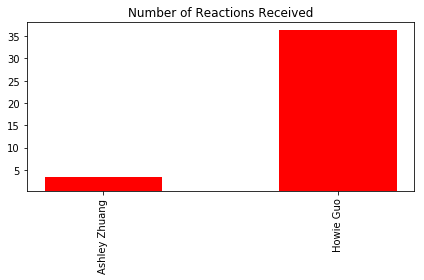

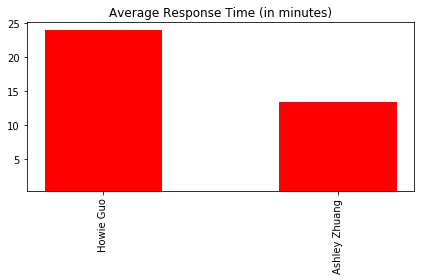

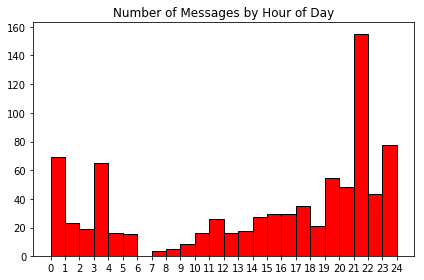

In [51]:
plot(0)

In [53]:
print_grade_level(0)

READABILITY GRADE LEVEL
Ashley Zhuang: Grade 3
Howie Guo: Grade 2
